# Chest-prediction - V2


## Setup

In [1]:
import tensorflow as tf

tf.__version__

'2.15.0'

In [2]:
AUTOTUNE = tf.data.AUTOTUNE

## Download and inspect the dataset

### Retrieve the images

Before you start any training, you'll need to download the dataset. I already resized the original dataset of the images to pass from 45GB to 3GB.

In [3]:
import os
from pathlib import Path

project_name = "chest-predictor"
username = os.environ.get('USER')

#Set variables (origin url, destination folder, folder name)
data_url = 'https://storage.googleapis.com/chest-predictor-data/resized_dataset.zip'
data_dir = f"/Users/{username}/code/sachamagier/{project_name}/raw_data"
data_fname = 'resized_dataset.zip'


#Downloading the dataset
data_root_orig = tf.keras.utils.get_file(
    fname=os.path.join(data_dir, data_fname),
    origin=data_url
)

Unzip the dataset download from GCS

** **Uncomment the block below if you need to unzip the file** **

In [6]:
#import zipfile

#Extract the dataset
#with zipfile.ZipFile(data_root_orig, 'r') as zip_ref:
    #zip_ref.extractall(data_dir)

In [4]:
#Set the new data_root
data_root = Path(os.path.join(data_dir, 'resized_dataset'))
print(data_root)

/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset


In [5]:
#This remove the '__MACOSX' file that is created on Mac Laptops
import shutil

if Path(os.path.join(data_dir, "__MACOSX")).is_dir():
    # remove the __MACOSX folder if it exists
    shutil.rmtree("../raw_data/__MACOSX")

In [6]:
#Get all image paths
all_image_paths = [str(path) for path in (data_root/"images"/"set_full").iterdir()]

In [7]:
image_count = len(all_image_paths)
image_count

111601

** **Uncomment this block below if if it's the first time you download and unzip the dataset and didn't get a len(all_image_paths) of 111601 - it will find all (256,256,4) images and delete them** **

In [11]:
#from PIL import Image

## specify your dataset directory
#data_directory = data_root/"images"/"set_full"

## list to store the names of the images to be removed
#images_to_remove = []

## iterate over all files in the dataset directory
#for filename in os.listdir(data_directory):
    #if filename.endswith(".png"):  # make sure it's a png file
        #file_path = os.path.join(data_directory, filename)
        #image = Image.open(file_path)  # load the image with Pillow

        ## convert the image to a numpy array to check its shape
        #image_array = np.array(image)

        ## check the shape of the image
        #if image_array.shape == (256, 256, 4):
            #images_to_remove.append(filename)  # add the filename to the list if it's to be removed

## print the names of the images to be removed
#print("Images to be removed: ", images_to_remove)

## uncomment the following line if you're sure about the images to be removed
# [os.remove(os.path.join(data_directory, filename)) for filename in images_to_remove]


In [12]:
#print(images_to_remove)

In [13]:
#Path(os.path.join(data_directory, filename))

In [14]:
#for filename in images_to_remove:
    #if os.path.exists(os.path.join(data_directory, filename)):
        #os.remove(os.path.join(data_directory, filename))
        #print(f"{filename} deleted")
    #else:
        #print("The file does not exist")

In [15]:
#image_count = len(all_image_paths)
#image_count

In [8]:
all_image_paths[:10]

['/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00018805_001.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00005868_002.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00009663_000.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00022156_007.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00005395_004.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00006966_004.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00000324_013.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00007442_018.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/se

### Inspect the images
Now let's have a quick look at a couple of the images, so you know what you're dealing with:

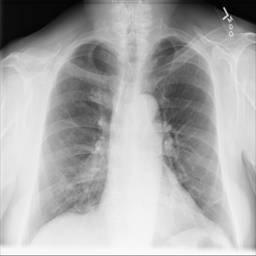

00013834_015.png



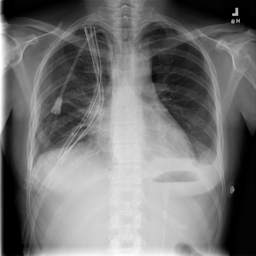

00010279_005.png



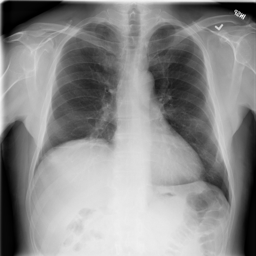

00027692_000.png



In [10]:
import IPython.display as display
import random

for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(os.path.basename(image_path))
    print()

### Determine the label for each image

Extracting the labels from the CSV

In [11]:
import pandas as pd
# Load labels
labels_df = pd.read_csv(data_root/"Data_Entry_2017.csv")
labels_df.set_index('Image Index', inplace=True)

In [12]:
labels_df.head(25)

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
Image Index,,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN
00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN


In [13]:
# Create list of all image labels
all_image_labels = labels_df.loc[[os.path.basename(path) for path in all_image_paths], 'Finding Labels'].values

In [14]:
all_image_labels[:25]

array(['No Finding', 'No Finding', 'No Finding', 'Pneumonia',
       'No Finding', 'Pneumonia', 'No Finding', 'No Finding',
       'No Finding', 'No Finding', 'No Finding',
       'Atelectasis|Infiltration', 'Fibrosis', 'Infiltration',
       'No Finding', 'No Finding', 'No Finding', 'No Finding',
       'No Finding', 'Atelectasis', 'Cardiomegaly', 'Infiltration',
       'Consolidation', 'No Finding', 'No Finding'], dtype=object)

In [15]:
len(all_image_labels)

111601

#### Encoding the labels

Encoding the labels using *StringLookup*

In [16]:
#Creating a list of the 15 different labels
label_names = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']

In [17]:
string_lookup = tf.keras.layers.StringLookup(vocabulary=label_names, num_oov_indices=0)

/Users/arnodebelle/.pyenv/versions/3.10.6/envs/chest_predictor/lib/python3.10/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [18]:
# Vectorized encoding of labels
def encode_labels(labels):
    split_labels = tf.strings.split(labels, '|')
    encoded_labels = string_lookup(split_labels)
    one_hot_encoded = tf.reduce_sum(tf.one_hot(encoded_labels, depth=len(label_names)), axis=0)
    return one_hot_encoded

** **Uncomment below if you don't have a CSV file with all encoded and sorted label -encoded_labels.csv-** **

In [19]:
## Apply encoding to all labels in a vectorized manner
#encoded_values = tf.stack([encode_labels(labels) for labels in all_image_labels])

In [20]:
#labels_np = encoded_values.numpy()

In [21]:
#labels_np[:10]

In [22]:
#labels_df = pd.DataFrame(labels_np) #convert to a dataframe
#labels_df.to_csv("../raw_data/encoded_labels.csv",index=False) #save to file

Ready CSV to extract all encoded labels

In [23]:
df_labels = pd.read_csv("../raw_data/encoded_labels.csv")

In [24]:
new_encoded_values = tf.convert_to_tensor(df_labels.values, dtype=tf.float32)

In [25]:
encoded_values = new_encoded_values

In [26]:
#Converting to numpy array for printing
encoded_values_np = encoded_values.numpy()

In [27]:
print("Encoded values:")
print(encoded_values_np[:10])

Encoded values:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [28]:
#Checking the lenght
len(encoded_values_np)

111601

If we need to find back the labels, here is the dictionnary of labels

In [29]:
vocab = string_lookup.get_vocabulary()

# Display the vocabulary and their corresponding indices
for i, label in enumerate(vocab):
    print(f"Index {i}: {label}")

Index 0: Atelectasis
Index 1: Consolidation
Index 2: Infiltration
Index 3: Pneumothorax
Index 4: Edema
Index 5: Emphysema
Index 6: Fibrosis
Index 7: Effusion
Index 8: Pneumonia
Index 9: Pleural_Thickening
Index 10: Cardiomegaly
Index 11: Nodule
Index 12: Mass
Index 13: Hernia
Index 14: No Finding


Creating a tensor Dataset for encoded labels

In [30]:
# Convert encoded values to tensor slices for the dataset
label_ds = tf.data.Dataset.from_tensor_slices(encoded_values)

In [31]:
label_ds

<_TensorSliceDataset element_spec=TensorSpec(shape=(15,), dtype=tf.float32, name=None)>

### Load and format the images

In [32]:
img_path = all_image_paths[0]
img_path

'/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00018805_001.png'

here is the raw data:

In [33]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x00\x00\...


Decode it into an image tensor:

In [34]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(256, 256, 1)
<dtype: 'uint8'>


Let's wrap up these up in simple functions for later.

In [35]:
img_final = tf.image.resize(img_tensor, [224, 224])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())


(224, 224, 1)
0.0
0.9879553


In [36]:
def preprocess_image(image):
    # convert it to rgb => VGG16 takes RGB image only
    image = tf.image.grayscale_to_rgb(image)

    # Resize the image to a width and a height of 256 pixels
    image = tf.image.resize(image, [224, 224], method='nearest')
    # Normalize the pixel values of the image to the range of [0, 1] => WE DON'T NEED FOR VGG16 (but we finally use another one...)
    image /= 255

    return image

In [37]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    # Decode the image contents
    img_tensor = tf.image.decode_png(image)[:,:,0:1]
    # return img_tensor
    return preprocess_image(img_tensor)

In [38]:
# Testing on one image
image1 = load_and_preprocess_image(all_image_paths[0])
image1

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.13333334, 0.13333334, 0.13333334],
        [0.05490196, 0.05490196, 0.05490196],
        [0.01568628, 0.01568628, 0.01568628],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314]],

       [[0.13333334, 0.13333334, 0.13333334],
        [0.05490196, 0.05490196, 0.05490196],
        [0.01568628, 0.01568628, 0.01568628],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314]],

       [[0.12941177, 0.12941177, 0.12941177],
        [0.05098039, 0.05098039, 0.05098039],
        [0.01568628, 0.01568628, 0.01568628],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314]],

       ...,

       [[0.20784314, 0.20784314, 0.20784314],
        [0.16

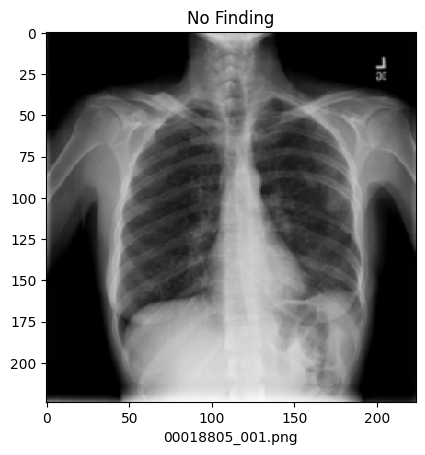

In [39]:
import matplotlib.pyplot as plt

img_path = all_image_paths[0]
label = all_image_labels[0]
encoded_lab = encoded_values[0]

plt.imshow(load_and_preprocess_image(img_path), cmap="gray")
plt.grid(False)
plt.xlabel(os.path.basename(img_path))
plt.title(label.title())
print()

## Build a `tf.data.Dataset`

### A dataset of images

The easiest way to build a tf.data.Dataset is using the from_tensor_slices method.

Slicing the array of strings results in a dataset of strings:

In [40]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [41]:
path_ds

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [42]:
for p in path_ds.take(4):
    print(p)

tf.Tensor(b'/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00018805_001.png', shape=(), dtype=string)
tf.Tensor(b'/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00005868_002.png', shape=(), dtype=string)
tf.Tensor(b'/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00009663_000.png', shape=(), dtype=string)
tf.Tensor(b'/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00022156_007.png', shape=(), dtype=string)


Now create a new dataset that loads and formats images on the fly by mapping `preprocess_image` over the dataset of paths.

In [43]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

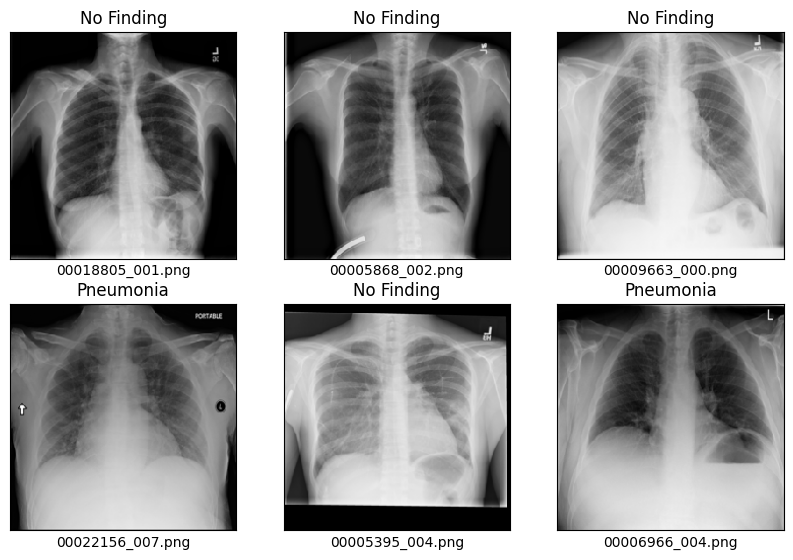

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for n,image in enumerate(image_ds.take(6)):
    ax = plt.subplot(3,3,n+1)
    plt.imshow(image, cmap='gray')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(os.path.basename(all_image_paths[n]))
    plt.title(all_image_labels[n].title())

plt.show()

### A dataset of `(image, label)` pairs


In [50]:
for label in label_ds.take(10):
  print(label)

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)


We have arrays `all_image_labels` and `all_image_paths` so We can use `tf.data.dataset.Dataset.zip` to slicing the pair of arrays.

In [51]:
path_label_ds = tf.data.Dataset.from_tensor_slices((all_image_paths, encoded_values))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = path_label_ds.map(load_and_preprocess_from_path_label)
image_label_ds

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(15,), dtype=tf.float32, name=None))>

### Basic methods for training


To train a model with this dataset we want the data:

* To be well shuffled.
* To be batched.
* To repeat forever.
* To have batches available as soon as possible.

These features can be easily added using the `tf.data` api.

### Creating X and y (train, val and test)

In [52]:
train_size = int(0.6 * len(all_image_paths))
val_size = int(0.2 * len(all_image_paths))
test_size = int(0.2 * len(all_image_paths))

In [53]:
train_ds = image_label_ds.take(train_size)

In [54]:
val_ds = image_label_ds.skip(train_size).take(val_size)

In [55]:
test_ds = image_label_ds.skip(train_size + val_size).take(test_size)

In [56]:
BATCH_SIZE = 32

def creating_batch_dataset(dataset, BATCH_SIZE, AUTOTUNE):
    ds = dataset.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [57]:
ds = creating_batch_dataset(image_label_ds, BATCH_SIZE, AUTOTUNE)
train_ds = creating_batch_dataset(train_ds, BATCH_SIZE, AUTOTUNE)
val_ds = creating_batch_dataset(val_ds, BATCH_SIZE, AUTOTUNE)
test_ds = creating_batch_dataset(test_ds, BATCH_SIZE, AUTOTUNE)

In [58]:
#BATCH_SIZE = 32

## Setting a shuffle buffer size as large as the dataset ensures that the data is
## completely shuffled.
##ds = image_label_ds.shuffle(buffer_size=image_count) => Finally, don't shuffle, it slows everythind down!
#ds = image_label_ds.repeat()
#ds = ds.batch(BATCH_SIZE)
## `prefetch` lets the dataset fetch batches, in the background while the model is training.
#ds = ds.prefetch(buffer_size=AUTOTUNE)
#ds

### Pipe the dataset to a model

converted to -1 to 1

In [59]:
# rearrange to -1 to 1
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

In [60]:
image_batch, label_batch = next(iter(keras_ds))

**Creating datasets with -1 to 1**

In [61]:
full_ds = ds.map(change_range)
train_converted_ds = train_ds.map(change_range)
val_converted_ds = val_ds.map(change_range)
test_converted_ds = test_ds.map(change_range)

Metrics

In [62]:
AUC = tf.keras.metrics.AUC(multi_label=True)

Model

In [63]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)
mobile_net.trainable=False

In [64]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 7, 7, 1280)


In [66]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'sigmoid')])

In [67]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.02194932
max logit: 0.9290472

Shape: (32, 15)


In [68]:
from tensorflow.keras import optimizers
model.compile(optimizer=optimizers.legacy.Adam(),
              loss='binary_crossentropy',
              metrics=["accuracy", AUC])

In [69]:

len(model.trainable_variables)

2

In [70]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 2277199 (8.69 MB)
Trainable params: 19215 (75.06 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [71]:
STEPS_PER_EPOCH=tf.math.ceil(train_size/BATCH_SIZE).numpy() #alternative = len(all_image_paths)
STEPS_PER_EPOCH

2093.0

In [72]:
STEPS_PER_EPOCH_VAL=tf.math.ceil(val_size/BATCH_SIZE).numpy() #alternative = len(all_image_paths)
STEPS_PER_EPOCH_VAL

698.0

In [76]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_auc', #'val_multilabel_f1_score',  # the name of the metric will be its prefix + '_' + its function name
                   mode='max',
                   patience=2,
                   verbose=1,
                   restore_best_weights=True)

model_checkpoint = ModelCheckpoint(filepath= os.path.join(data_dir, 'best_model2.keras'),
                                   save_best_only=True,
                                   monitor='val_auc')

In [77]:
EPOCHS = 50

history = model.fit(train_converted_ds,
                    validation_data=val_converted_ds,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=STEPS_PER_EPOCH,
                    callbacks=[es, model_checkpoint])


Epoch 1/50
2093/2093 [==============================] - 833s 398ms/step - loss: 0.1971 - accuracy: 0.5322 - auc: 0.7334 - val_loss: 0.2010 - val_accuracy: 0.5178 - val_auc: 0.7213
Epoch 2/50
2093/2093 [==============================] - 825s 394ms/step - loss: 0.1950 - accuracy: 0.5344 - auc: 0.7508 - val_loss: 0.2012 - val_accuracy: 0.5201 - val_auc: 0.7223
Epoch 3/50
2093/2093 [==============================] - 832s 398ms/step - loss: 0.1935 - accuracy: 0.5358 - auc: 0.7615 - val_loss: 0.2014 - val_accuracy: 0.5177 - val_auc: 0.7238
Epoch 4/50
2093/2093 [==============================] - 826s 395ms/step - loss: 0.1926 - accuracy: 0.5372 - auc: 0.7685 - val_loss: 0.2014 - val_accuracy: 0.5222 - val_auc: 0.7224
Epoch 5/50
2093/2093 [==============================] - 802s 383ms/step - loss: 0.1918 - accuracy: 0.5373 - auc: 0.7735 - val_loss: 0.2013 - val_accuracy: 0.5200 - val_auc: 0.7238
Epoch 5: early stopping


In [78]:
from tensorflow.keras.models import save_model

models_dir = '../models'

# Ensure that the models directory exists
os.makedirs(data_dir, exist_ok=True)


# Save the trained model to the models directory
save_model(model, os.path.join(data_dir, 'ADE_final_model2.keras'))

In [79]:
history

In [80]:
STEPS_PER_EPOCH_TEST=tf.math.ceil(test_size/BATCH_SIZE).numpy() #alternative = len(all_image_paths)
STEPS_PER_EPOCH_TEST

698.0

In [81]:
results = model.evaluate(test_ds, steps=STEPS_PER_EPOCH, verbose=0)
print(f"Test AUC: {results[2]}")

Test AUC: 0.7115424871444702
